In [1]:
import ast
import os
import itertools
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Read data
games = pd.read_csv("Data/games_detailed_info.csv", index_col=0) # review stats


In [3]:
n_rows, n_cols = games.shape

In [4]:
# 1. Remove columns with > 20% of NA values 
na_threshold = 0.2
key_columns = [colname for colname in games.columns if games[colname].isna().sum() <= na_threshold*n_rows]

print("Columns with > {}% of NA values: \n".format(na_threshold*100), set(games.columns)-set(key_columns))

Columns with > 20.0% of NA values: 
 {'boardgameimplementation', 'Accessory Rank', 'boardgameexpansion', 'Abstract Game Rank', 'Family Game Rank', 'War Game Rank', 'Strategy Game Rank', 'Thematic Rank', "Children's Game Rank", 'Atari ST Rank', 'boardgamecompilation', 'Amiga Rank', 'Arcade Rank', 'Commodore 64 Rank', 'alternate', 'boardgameartist', 'Party Game Rank', 'Video Game Rank', 'boardgameintegration', 'boardgamefamily', 'RPG Item Rank', 'Customizable Rank'}


In [5]:
# 2. Remove redundant/unnecesary columns
unnecessary_columns = ["type", "thumbnail", "image", "suggested_num_players", "suggested_playerage", 
                       "suggested_language_dependence"]
key_columns = [x for x in key_columns if x not in unnecessary_columns]

In [6]:
# 3. Rename confusing column names
games = games.loc[:,key_columns]
games.rename(columns={"primary": "name", "usersrated": "numratings", "average": "avgrating",
                      "boardgamecategory": "category", "boardgamemechanic": "mechanic", 
                      "boardgamedesigner": "designer", "boardgamepublisher": "publisher", 
                      "bayesaverage": "bayesavgrating", "Board Game Rank": "rank", 
                      "stddev": "stdrating", "median": "medianrating",
                      "owned": "numowned", "trading": "numtrades", "wanting":"numwants", 
                      "wishing": "numwishes"}, inplace=True)

In [7]:
# 4. Parse columns with list values
# Convert list of strings to list
for list_col in ["category", "mechanic", "designer", "publisher"]:
    games[list_col] = games[list_col].apply(lambda x: ast.literal_eval(x) if not(pd.isna(x)) else [])

In [8]:
def create_df_with_binary_columns(df, colname, n_binary_cols):
    """
    TBD
    """
    new_df = df.copy()
    cnt = list(itertools.chain.from_iterable(df[colname]))
    cnt = Counter(cnt)
    common_items = [x[0] for x in cnt.most_common(n_binary_cols)]
    for col in common_items:
        new_df[col] = new_df[colname].apply(lambda x: col in x)
    return(new_df, cnt.most_common(n_binary_cols))

In [9]:
# Create new dataframes with binary columns of 20 popular items
games_category, category_cnt = create_df_with_binary_columns(games, "category", 20)
games_mechanic, mechanic_cnt = create_df_with_binary_columns(games, "mechanic", 20)
games_designer, designer_cnt = create_df_with_binary_columns(games, "designer", 20)
games_publisher, publisher_cnt = create_df_with_binary_columns(games, "publisher", 20)

In [10]:
# Plot the histogram of popular items
all_cnts = [("category", category_cnt), ("mechanic", mechanic_cnt), 
           ("designer", designer_cnt), ("publisher", publisher_cnt)]

In [11]:
games.columns

Index(['id', 'name', 'description', 'yearpublished', 'minplayers',
       'maxplayers', 'playingtime', 'minplaytime', 'maxplaytime', 'minage',
       'category', 'mechanic', 'designer', 'publisher', 'numratings',
       'avgrating', 'bayesavgrating', 'rank', 'stdrating', 'medianrating',
       'numowned', 'numtrades', 'numwants', 'numwishes', 'numcomments',
       'numweights', 'averageweight'],
      dtype='object')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  


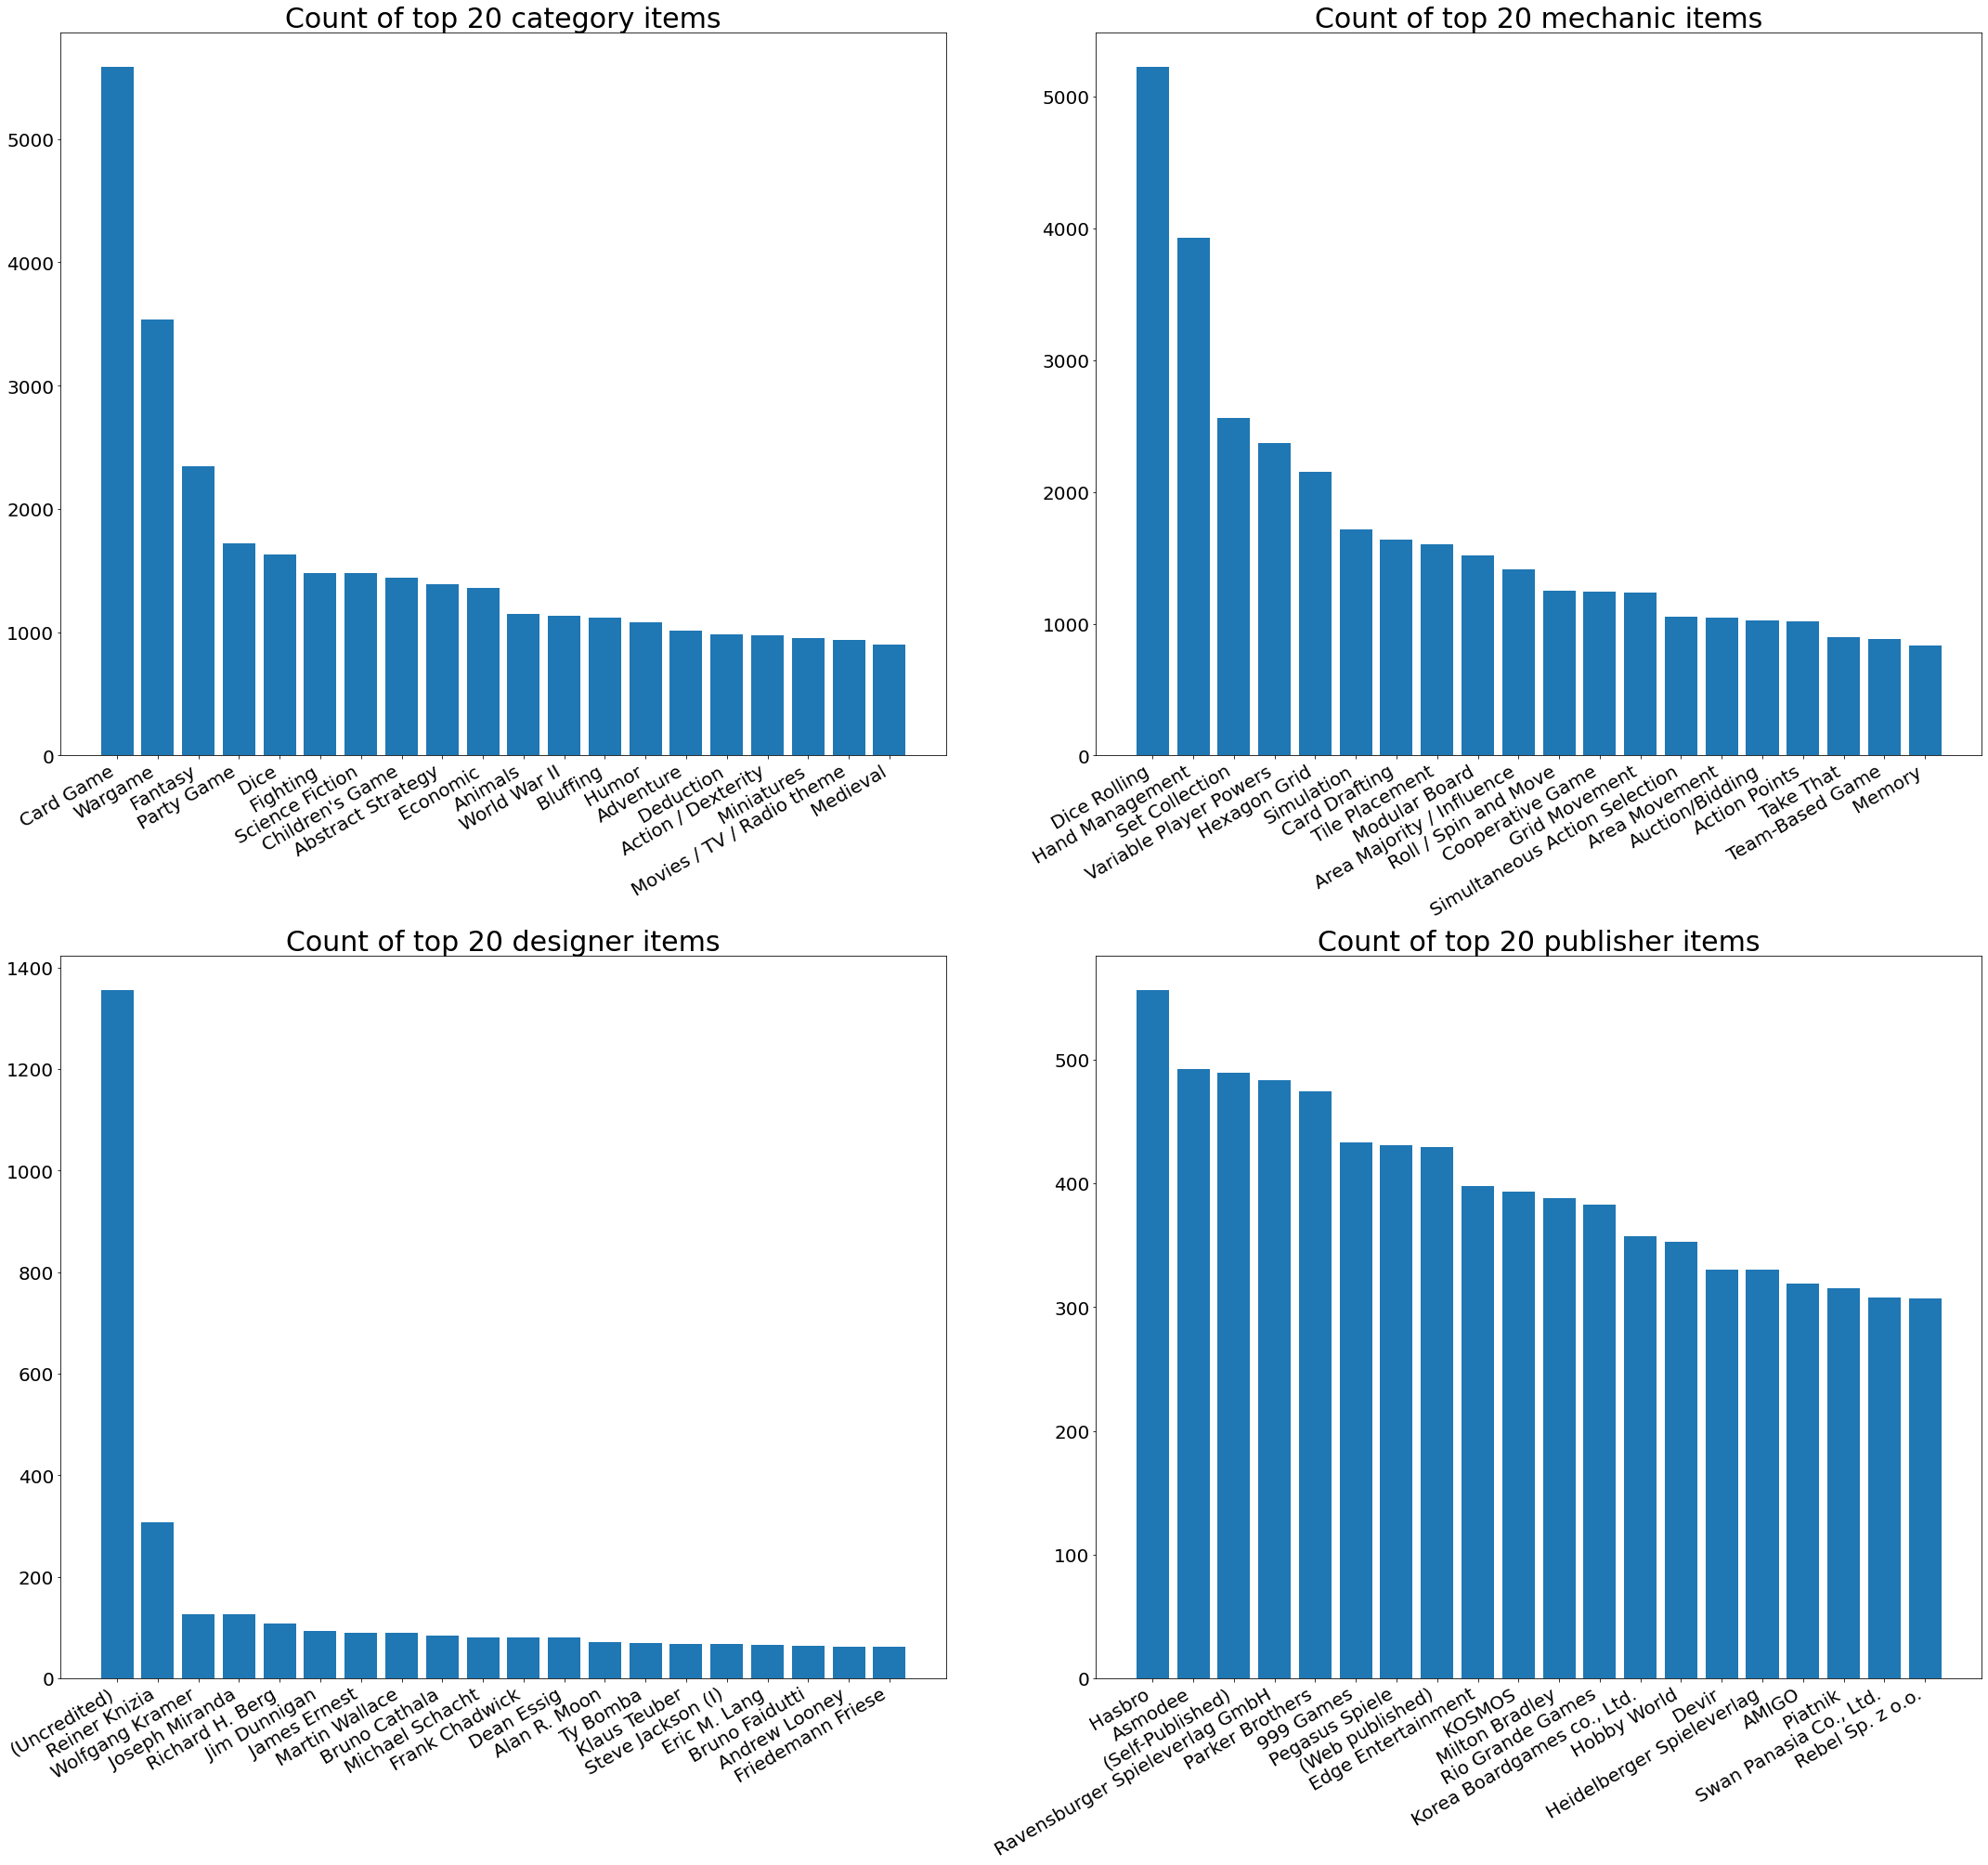

In [12]:
fig = plt.figure(figsize=(30,28))

for i, tup in enumerate(all_cnts):
    ax = plt.subplot(2, 2, i+1)
    ax.bar([x[0] for x in tup[1]], [x[1] for x in tup[1]])
    ax.set_xticklabels([x[0] for x in tup[1]], rotation=30,  ha="right")
    ax.set_title("Count of top 20 {} items".format(tup[0]), fontsize=30)
    ax.tick_params(labelsize=20)
fig.tight_layout()

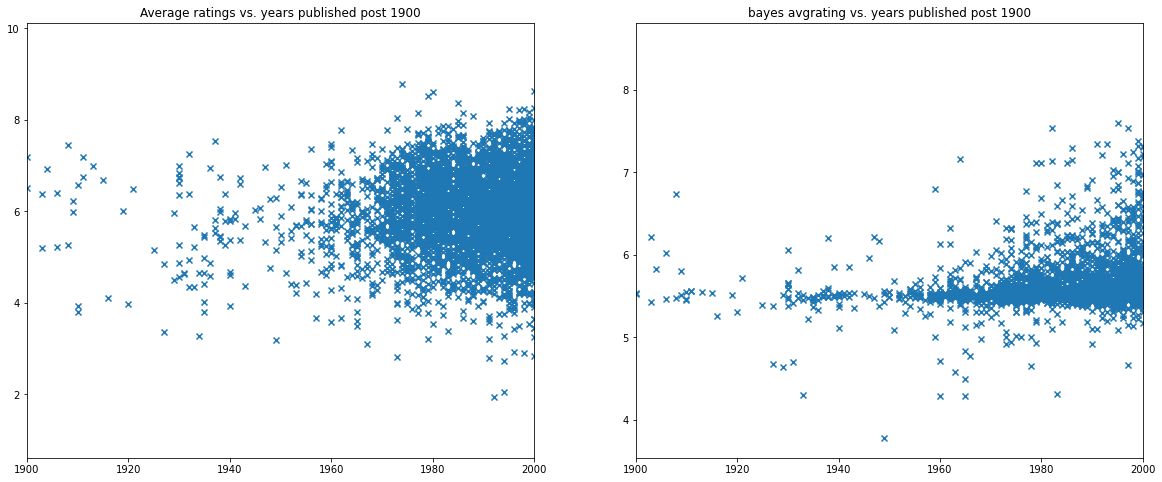

The correlation between years published and average user ratings are 0.33
The correlation between years published and bayes average rating are 0.17


In [13]:
#see the trend of ratings vs. years after 1900

year_vs_rating = games[['yearpublished', 'avgrating', 'bayesavgrating']].copy()
after_1900 = year_vs_rating[year_vs_rating['yearpublished']>=1900]

fig = plt.figure(figsize = (20, 8))
ax = plt.subplot(1, 2, 1)
ax.scatter(after_1900['yearpublished'], after_1900['avgrating'], marker = 'x')
ax.set_title('Average ratings vs. years published post 1900')
ax.set_xlim([1900, 2000])

ax2 = plt.subplot(1, 2, 2)
ax2.scatter(after_1900['yearpublished'], after_1900['bayesavgrating'], marker = 'x')
ax2.set_title('bayes avgrating vs. years published post 1900')
ax2.set_xlim([1900, 2000])


plt.show()
print('The correlation between years published and average user ratings are {:3.2f}'.format(after_1900['yearpublished'].corr(after_1900['avgrating'])))
print('The correlation between years published and bayes average rating are {:3.2f}'.format(after_1900['yearpublished'].corr(after_1900['bayesavgrating'])))

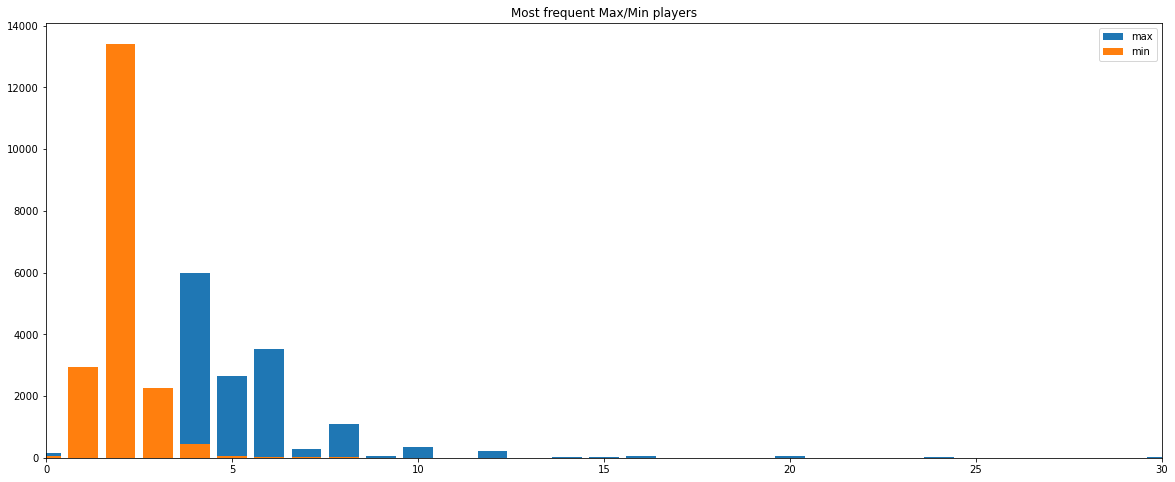

In [14]:
#see how min/max players distributed

numplayers_ratings = games[['maxplayers', 'minplayers']]

z = Counter(numplayers_ratings['maxplayers'])
y = Counter(numplayers_ratings['minplayers'])

fig = plt.figure(figsize = (20, 8))
plt.title('Most frequent Max/Min players')
plt.bar(z.keys(), z.values(), label = 'max')
plt.bar(y.keys(),y.values(), label = 'min')
plt.legend(loc="upper right")
plt.xlim([0, 30])
plt.show()